# Grape V1 Data Plots
The purpose of this notebook is to provide a one-stop shop for plotting data from the prototype of the Grape 1 Low-Cost Personal Space Weather Station. 

This notebook was created by Kristina Collins KD8OXT. Code was contributed by Aidan Montare KB3UMD and Bob Benedict KD8CGH. Hardware designed by John Gibbons. Node maintainers are listed in the `nodelist.csv` file which accompanies this notebook.

## Instructions:
Data is permanently stored at [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.6622112.svg)](https://doi.org/10.5281/zenodo.6622112). To use this notebook, download the data from the repository and unzip it into the `data/` directory.

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import datetime as dt
# from datetime import time
from datetime import date
import time
import pytz
import numpy as np
import seaborn as sns; sns.set_theme()
import matplotlib as mpl
import wget
import os
import matplotlib.pyplot as plt
# from adjustText import adjust_text                                # For map labels
# import tqdm 
import sys  
# sys.path.insert(0, '/path/to/application/app/folder')
from Beacon import readheader                                     # local .py file

# Directory tools:
from os import listdir                                           
from os.path import isfile, join

# multiplot utilities:
from os import path
import sys
import csv
import math
#import shutil  # uncomment for pi
#from datetime import date, timedelta  # uncomment for pi
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt, butter
import datetime  
from suntime import Sun
from WWV_utility2 import time_string_to_decimals                              # python file in this directory
from Beacon import readheader

from os.path import exists                                                    #  to have wget check for duplicates

import csv                                                                    # to save and read .csv files



# Generate Data Overview
The first step is to pull the list of filenames from the server maintained by the WWV Amateur Radio Club, WW0WWV. We will then generate a pandas dataframe from the filename list using the split() function. This will tell us the earliest and latest dates of data collection; we can use these as the bounds of our analysis, or substitute in a smaller set of bounds. We'll use this to create a Gantt chart showing station availability, and maybe keograms of our data over time. While we're at it, we can also generate two versions of a station map: one static, to put in our paper; and one dynamic, showing which stations were active at a given point in time. 

In [2]:
# List of files:
mypath = 'data/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
df = pd.DataFrame(onlyfiles)
df

0
0     2019-05-24T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...
1     2019-05-25T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...
2     2019-05-26T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...
3     2019-05-27T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...
4     2019-05-28T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...
...                                                 ...
8530  2022-05-31T000000Z_N0000039_G1_EM73ut_FRQ_WWV1...
8531  2022-05-31T000000Z_N0000040_S1_EM38ww_FRQ_WWV5...
8532  2022-05-31T000000Z_N00010_G1_EN91ii_FRQ_WWV10.csv
8533  2022-05-31T000001Z_N0000029_G1_DM45dc_FRQ_WWV1...
8534  2022-05-31T000001Z_N0000038_G1_EN71ia_FRQ_WWV1...

[8535 rows x 1 columns]

In [3]:
# Eliminate .pngs from our file list:
df = df[~df[0].str.contains('.png')]
df.columns =['Filename']
df2 = df['Filename'].str.split('_', expand=True)
df2.columns =['Datetime', 'Node', 'G', 'Grid Square', 'FRQ', 'Frequency']
df2 = df2.drop(columns=['FRQ']) # no information in this columnn
df2["Frequency"] = df2["Frequency"].str.replace(".csv","")
df = pd.concat([df2, df], axis = 1) # concatenate dataframes horizontally
df['Datetime']= pd.to_datetime(df['Datetime']) # cast to datetime
df['Node'] =df['Node'].str.strip("N")                   # Ditch the leading N on the node numbers
df['Node'] = df['Node'].astype(str).astype(int)         # Cast node number to int
df = df[~df['Frequency'].str.contains('G1')]            # discarding files with naming errors


# Convert frequency abbreviations to numbers:

df.loc[df['Frequency'] == 'WWV5', 'Frequency'] = 5e6
df.loc[df['Frequency'] == 'WWV10', 'Frequency'] = 10e6
df.loc[df['Frequency'] == 'WWV2p5', 'Frequency'] = 2.5e6
df.loc[df['Frequency'] == 'WWV15', 'Frequency'] = 15e6
df.loc[df['Frequency'] == 'CHU3', 'Frequency'] = 3330e3
df.loc[df['Frequency'] == 'CHU7', 'Frequency'] = 7850e3
df.loc[df['Frequency'] == 'CHU14', 'Frequency'] = 14.67e6
df.loc[df['Frequency'] == 'Unknown', 'Frequency'] = 0

df

Datetime  Node   G Grid Square Frequency  \
0    2019-05-24 00:00:00+00:00     1  G1      EN91fh     5e+06   
1    2019-05-25 00:00:00+00:00     1  G1      EN91fh     5e+06   
2    2019-05-26 00:00:00+00:00     1  G1      EN91fh     5e+06   
3    2019-05-27 00:00:00+00:00     1  G1      EN91fh     5e+06   
4    2019-05-28 00:00:00+00:00     1  G1      EN91fh     5e+06   
...                        ...   ...  ..         ...       ...   
8530 2022-05-31 00:00:00+00:00    39  G1      EM73ut     1e+07   
8531 2022-05-31 00:00:00+00:00    40  S1      EM38ww     5e+06   
8532 2022-05-31 00:00:00+00:00    10  G1      EN91ii     1e+07   
8533 2022-05-31 00:00:01+00:00    29  G1      DM45dc     1e+07   
8534 2022-05-31 00:00:01+00:00    38  G1      EN71ia     1e+07   

                                               Filename  
0     2019-05-24T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...  
1     2019-05-25T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...  
2     2019-05-26T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...  
3     2019-05-27T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...  
4     2019-05-28T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...  
...                                                 ...  
8530  2022-05-31T000000Z_N0000039_G1_EM73ut_FRQ_WWV1...  
8531  2022-05-31T000000Z_N0000040_S1_EM38ww_FRQ_WWV5...  
8532  2022-05-31T000000Z_N00010_G1_EN91ii_FRQ_WWV10.csv  
8533  2022-05-31T000001Z_N0000029_G1_DM45dc_FRQ_WWV1...  
8534  2022-05-31T000001Z_N0000038_G1_EN71ia_FRQ_WWV1...  

[8534 rows x 6 columns]

In [4]:
# We can create a Gantt chart showing when different stations were active. 
gantt = df.copy()

# # # Filter by day:
sTime_tmp = datetime.datetime(2021,10,28, tzinfo = pytz.UTC)
eTime_tmp = datetime.datetime(2021,10,29, tzinfo = pytz.UTC)
# gantt = gantt[(gantt['Datetime'] >= sTime_tmp) & (gantt['Datetime'] <= eTime_tmp)].copy()


# List of logged nodes during the period of interest, for sorting:
logged_nodes = df["Node"].unique().tolist()
logged_nodes.sort()

gantt.set_index('Node')
gantt = gantt.drop(columns=['G', 'Grid Square'])#, 'Filename'])
gantt['EndTime'] = gantt['Datetime']+ datetime.timedelta(days=1) # create an end
# For now, let's look at one frequency at a time.
# rows = gantt['Frequency']=='WWV5' # can change this to look at a different freq of interest.
# gantt = gantt.loc[gantt['Frequency'] == 'WWV2p5']

gantt['Filename'].str.strip('FRQ_')

# fig = px.timeline(gantt, x_start="Datetime", x_end="EndTime", y="Node", color="Frequency", text = "Filename", category_orders={"Node": logged_nodes})
fig = px.timeline(gantt, x_start="Datetime", x_end="EndTime", y="Node", color="Frequency", category_orders={"Node": logged_nodes})
# fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.update_yaxes(type='category')
fig.update_annotations(text = "Filename", clicktoshow='on')


fig.show()
fig.write_html("gantt.html", include_plotlyjs="cdn")

In [5]:
# Read in node list:
nodes = pd.read_csv ('nodelist.csv',  encoding='cp1252')
nodes = nodes[1:42] # discarding extra rows - this should be dynamically assigned, but is manual for now.
nodes = nodes.rename(columns={'Node #': 'Node_Number'})

# Just the nodes that have data:
# logged_nodes = df["Node"].unique().tolist()
# logged_nodes.sort()
# logged_nodes = [s.lstrip('N') for s in logged_nodes]
test_list = list(map(int, logged_nodes)) # cast to int

# tf = nodes['Node #']logged_nodes[] # true/false vector
# nodes['Node #'] in logged_nodes
# nodes['Node #']
nodes['Status'] = np.where((nodes.Node_Number.isin(logged_nodes)), "Data logged", "No data logged")
nodes

color = (nodes['Status'] == 'No data logged').map({True: 'background-color: pink', False: ''})
nodes.style.apply(lambda s: color)

In [6]:
# Map nodes:
fig = px.scatter_geo(nodes, "Latitude", "Longitude",
                     color="Status", # which column to use to set the color of markers
                     hover_name=nodes["Callsign"], # column added to hover information
                     projection = 'albers usa',
                     )

fig.show()

## Example of a concurrent daily plot
Let's use the multiplot function developed by Bob Benedict KD8CGH (https://github.com/rkayakr/ProcessPlot) to plot Grape data from multiple stations on the same date. October 28, 2021 is a good example date, because there were solar flares widely observed by Grape 1 stations.

The `multiplot` function is adapted from KD8CGH's code. It checks a text file in the local directory for the set of files to plot. We'll define the function, then make a list of files and call it. 

In [7]:

# from grapefunctions import multiplot

def multiplot(plotTitle = ' Grape Data Plot'):
    '''
        # !/usr/bin/env python3
    # -*- coding: utf-8 -*-
    PROCESSED FILE VERSION V1.0 built on multiPlot v1.2
    multiPlot version v1.2 cleans up to make Pi and Windows use easier
    multiPlot version v1.1 adds sunrise sunset times for location of lat long in first file
    requires suntime library https://github.com/SatAgro/suntime
    multiPlot version v1.0 plots up to 10 PSWS "rawdata" files and average value
    modified from WWV_plt2.py @authors dkazdan jgibbons
    expects a homepath directory with processed files in homepath or subdirs 
    leaves plot in Mplot directory
    plots files from multiple subdir to compare node results
    plot title from first file
    windows version hardcoded homepath directory location
    for Pi comment out windows homepath and uncomment Pi  lines
    uses WWV_utility2.py
    Bob Benedict, KD8CGH, 7/29/2021
    create text file "plotfiles.txt" in homepath directory
      keyword ('Doppler' or 'Power')
      keyword ('Average' or 'No Average')
      subdir/filename1 
      subdir/filename2
      filename3
      ...
    Note - expects all data from the same beacon
    if found 'Doppler' will plot Doppler shifts, else will plot Power
    if found "Average" will add average plot
    loads file names in list
    plots first file and create axis and title info
    plots rest in loop as curves on first plot
    calculates average and plots
    leaves plotfile in Mplot directory
    uses
    WWV_utility2.py
    20 February 2020
    WWV utility file
    Routines and classes used in WWV file management and graphing
    David Kazdan, AD8Y
    John Gibbons, N8OBJ - mods to plot header 2/3/20
    '''

    #import os # uncomment for pi
    from os import path
    import sys
    import csv
    import math
    #import shutil  # uncomment for pi
    #from datetime import date, timedelta  # uncomment for pi
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import filtfilt, butter
    import datetime  
    from suntime import Sun
    #import subprocess
    from WWV_utility2 import time_string_to_decimals
    from Beacon import readheader

    '''  #uncomment for Pi
    # ~ points to users home directory - usually /home/pi/
    homepath = os.path.expanduser('~')
    # embed the trailing / in the home path
    homepath = homepath + "/PSWS/"
    #comment out windows homepath
    '''

    homepath = ""#E:\\Documents\\PSWS\\"  # set your windows path, comment out for Pi

    names = open(homepath+"Processfiles.txt","r")

    PlotTarget = names.readline()
    PlotTarget = PlotTarget.strip('\n')
    PlotAverage = names.readline()
    if PlotAverage[0:7] == 'Average':
        doavg=True
    else:
        doavg=False

    Filenames=['a' for a in range (10)]
    Filedates=['a' for a in range (10)]
    #PrFilenames=['a' for a in range (10)]
    Nodenum=['a' for a in range (10)]
    Beaconname=['a' for a in range (10)]
    beaconfreq=np.zeros(10)

    nfiles = 0  # holder for number of files to plot

    colors=['b','g','r','c','m','y','tab:orange','tab:gray','tab:purple','tab:brown']

    while True:
        temp = names.readline()
        if  len(temp) <= 1:
            break
        Filenames[nfiles]=temp.strip("\n")
        fdate = Filenames[nfiles].find("/") # find start of filename after subdirectory
        if fdate==-1 :  # if / not found try \
            fdate = Filenames[nfiles].find("\\")
    #    print(" position ",fdate)
        # if neith / nor \ found file is in homepath, fdate=-1, following assignment still works
        Filedates[nfiles]=temp[fdate+1:fdate+11]
        nfiles=nfiles + 1

    print(Filenames[0:9])
    #print(Filedates[0:9])
    print('number of files',nfiles)
    if nfiles > 10 :
        print('10 file limit')
        sys.exit(0)

    PROCESSDIR = homepath

    #saved plot directory
    PlotDir = homepath + 'Mplot/'

    '''
    read first file
    '''
    PrFilenames=(PROCESSDIR + Filenames[0])

    if (path.exists(PrFilenames)):
        print('File ' + PrFilenames + ' found!\nProcessing...')
    else:
        print('File ' + PrFilenames + ' not available.\nExiting disappointed...')
        sys.exit(0)

    with open(PrFilenames, 'r') as dataFile:
        dataReader=csv.reader(dataFile)
        data = list(dataReader)
        Header = data.pop(0)

    #    print('return',readheader(0,Header))
        Nodenum[0], Beaconname[0], beaconfreq[0], Lat, Long = readheader(Header)
    #    print('\n returned ', Nodenum[0], Beaconname[0], beaconfreq[0], Lat, Long, '\n')

    ''' ###########################################################################
    '''
    print('Ready to start processing records')

    # Prepare data arrays
    hours=[[],[],[],[],[],[],[],[],[],[]]
    Doppler=[[],[],[],[],[],[],[],[],[],[]]
    #Vpk=[[],[],[],[],[],[],[],[],[],[]]
    Power_dB=[[],[],[],[],[],[],[],[],[],[]] # will be second data set, received power 9I20
    filtDoppler=[[],[],[],[],[],[],[],[],[],[]]
    filtPower=[[],[],[],[],[],[],[],[],[],[]]

    LateHour=False # flag for loop going past 23:00 hours

    # eliminate all metadata saved at start of file - Look for UTC (CSV headers)
    #find first row of data0
    FindUTC = 0

    for row in data:
        if (FindUTC == 0):
            #print('looking for UTC - row[0] =',row[0])
            if (row[0] == 'UTC'):
                FindUTC = 1
    #            print('UTC found =', row[0])
        else:
            #print('Processing record')
            decHours=time_string_to_decimals(row[0])
    #        if (NewHdr != 'New'):
    #            if (calccnt  < 101):
    #                calcnt = calcnt+1
    #                freqcalc = freqcalc + (float(row[1])/100)
    #        if decHours > 23:
    #            LateHour=True # went past 23:00 hours
            if (not LateHour) or (LateHour and (decHours>23)): # Otherwise past 23:59:59.  Omit time past midnight.
                hours[0].append(decHours) # already in float because of conversion to decimal hours.
                Doppler[0].append(float(row[1])-beaconfreq[0]) # frequency offset from col 2
    #            Vpk[0].append (float(row[2])) # Get Volts peak from col 3
                Power_dB[0].append (20*math.log10(float(row[2]))) # log power from col 4

    #print('nf ',0,'len hours',len(hours[0]))

    ###############################################################################################
    # Find max and min of Power_dB for graph preparation:
    min_power=np.amin(Power_dB[0]) # will use for graph axis min
    max_power=np.amax(Power_dB[0]) # will use for graph axis max

    min_Doppler=np.amin(Doppler[0]) # min Doppler
    max_Doppler=np.amax(Doppler[0]) # max Doppler

    print('\nDoppler min: ', min_Doppler, '; Doppler max: ', max_Doppler)
    print('dB min: ', min_power, '; dB max: ', max_power)

    #%% Create an order 3 lowpass butterworth filter.
    # This is a digital filter (analog=False)
    # Filtering at .01 to .004 times the Nyquist rate seems "about right."
    # The filtering argument (Wn, the second argument to butter()) of.01
    # represents filtering at .05 Hz, or 20 second weighted averaging.
    # That corresponds with the 20 second symmetric averaging window used in the 1 October 2019
    # Excel spreadsheet for the Festival of Frequency Measurement data.
    #FILTERBREAK=.005 #filter breakpoint in Nyquist rates. N. rate here is 1/sec, so this is in Hz.
    FILTERBREAK=0.005 #filter breakpoint in Nyquist rates. N. rate here is 1/sec, so this is in Hz.
    FILTERORDER=6
    b, a = butter(FILTERORDER, FILTERBREAK, analog=False, btype='low')
    #print (b, a)
    #%%
    # Use the just-created filter coefficients for a noncausal filtering (filtfilt is forward-backward noncausal)


    filtDoppler[0] = filtfilt(b, a, Doppler[0])

    filtPower[0] = filtfilt(b, a, Power_dB[0])

    ##################################################################################################
    # sunrise sunset times in UTC
    sun = Sun(float(Lat), float(Long))

    UTC_DT=Filedates[0]
    print(UTC_DT)
    SDAY=int(UTC_DT[8:10])
    SMON=int(UTC_DT[5:7])
    SYEAR=int(UTC_DT[0:4])
    sdate = datetime.date(SYEAR, SMON, SDAY)
    today_sr = sun.get_sunrise_time(sdate)
    today_ss = sun.get_sunset_time(sdate)
    #print(today_sr)
    srh=int(format(today_sr.strftime('%H')))
    srm=int(format(today_sr.strftime('%M')))
    srx=srh+srm/60
    ssh=int(format(today_ss.strftime('%H')))
    ssm=int(format(today_ss.strftime('%M')))
    ssx=ssh+ssm/60

    # set up x-axis with time
    fig = plt.figure(figsize=(19,10)) # inches x, y with 72 dots per inch
    ax = fig.add_subplot(111)
    ax.set_xlabel('UTC Hour')
    ax.set_xlim(0,24) # UTC day
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], minor=False)

    # plot first curve
    if (PlotTarget == 'Doppler'):
#         ax.plot([srx,srx],[-1,1],'y',label='sunrise',linestyle='dashed')      # Comment in to plot sunrise for first station
#         ax.plot([ssx,ssx],[-1,1],'b',label='sunset',linestyle='dashed')       # Comment in to plot sunset for first station
        ax.plot(hours[0], filtDoppler[0], colors[0],label=Beaconname[0] +' '+Nodenum[0]+' '+Filedates[0]) # color k for black
        ax.set_ylabel('Doppler shift, Hz '+ Filedates[0])
        ax.set_ylim([-1.0, 1.0]) # -1 to 1 Hz for Doppler shift
        plt.axhline(y=0, color="gray", lw=1) # plot a zero freq reference line for 0.000 Hz Doppler shift


    else:
        # ax.plot([srx,srx],[-90,0],'y',label='sunrise',linestyle='dashed')    # Comment in to plot sunrise for first station
        # ax.plot([ssx,ssx],[-90,0],'b',label='sunset',linestyle='dashed')     # Comment in to plot sunset for first station
        ax.plot(hours[0], filtPower[0], colors[0],label=Beaconname[0] +' '+ Nodenum[0]+' '+Filedates[0]) # color k for black
        ax.set_ylabel('Power, dB '+ Filedates[0])
        ax.set_ylim(-90, 0)    


    # add grid lines - RLB
    plt.grid(axis='both')

    '''
    ######################################################################
    read and plot files loop
    '''

    for nf in range(1, nfiles):
    # splot second curve
    # read second file, skip header
        print('process file ',nf, Filenames[nf])
        PrFilenames=(PROCESSDIR + Filenames[nf])
        with open(PrFilenames, 'r') as dataFile: # read second set
            dataReader=csv.reader(dataFile)
            data = list(dataReader)
            Header = data.pop(0)
            Nodenum[nf]= Header[2]
        FindUTC = 0

        Nodenum[nf], Beaconname[nf], beaconfreq[nf], Lat, Long = readheader(Header)
    #    print('\n returned ', Nodenum[nf], Beaconname[nf], beaconfreq[nf], Lat, Long, '\n')

        for row in data:
            if (FindUTC == 0):
                #print('looking for UTC - row[0] =',row[0])
                if (row[0] == 'UTC'):
                    FindUTC = 1
    #            print('UTC found =', row[0])
            else:
                decHours=time_string_to_decimals(row[0])
                hours[nf].append(decHours) # already in float because of conversion to decimal hours.
                Doppler[nf].append(float(row[1])-beaconfreq[nf]) # frequency offset from col 2
    #            Vpk[nf].append (float(row[2])) # Get Volts peak from col 3
    #            Power_dB[nf].append (float(row[4])) # log power from col 4    
                Power_dB[nf].append (20*math.log10(float(row[2]))) # log power
    # filter  file data
        filtDoppler[nf] = filtfilt(b, a, Doppler[nf])
        filtPower[nf] = filtfilt(b, a, Power_dB[nf])

        if (PlotTarget == 'Doppler'):    
            ax.plot(hours[nf], filtDoppler[nf], colors[nf], label=Beaconname[nf] +' '+ Nodenum[nf]+' '+Filedates[nf]) # color k for black
        else:
            ax.plot(hours[nf], filtPower[nf], colors[nf], label=Beaconname[nf] +' '+ Nodenum[nf]+' '+Filedates[nf]) # color k for black

    '''
    #############################################################################
    end for read and plot loop, start average
    '''
    # find shortest data set, limit average to that
    if doavg :
        al=1000000
        ak=0

        for k in range(nfiles):
            templ=len(hours[k])
            if templ < al:
                al=templ
                ak=k

        avg=[]

        if (PlotTarget == 'Doppler'):
            for i in range(al):
                temp=0.0
                for j in range(nfiles):
                    temp=temp+filtDoppler[j][i]
                temp=temp/nfiles
                avg.append(temp)
        else:
            for i in range(al):
                temp=0.0
                for j in range(nfiles):
                    temp=temp+filtPower[j][i]
                temp=temp/nfiles
                avg.append(temp)

        #print('avg',len(avg))

        ax.plot(hours[ak], avg, 'k', label='Average') # color k for black

    '''
    end average
    '''
    ax.legend(loc="lower right",  frameon=False)


    # Create Plot Title
    plt.title(plotTitle)
    #plt.title(beaconlabel + ' Grape Data Plot\nNode:  ' + node + '     Gridsquare:  '+ GridSqr + '\nLat= ' + Lat + '    Long= ' + Long + '    Elev= ' + Elev + ' M\n' )
    # Create Plot File Nam
    #GraphFile = yesterdaystr + '_' + node + '_' + RadioID + '_' + GridSqr + '_' + beacon + '_graph.png'
    GraphFile = 'multi'+ PlotTarget + '.png'
    PlotGraphFile = PlotDir + GraphFile

    # create plot
    #plt.savefig(PlotDir + yesterdaystr + '_' + node + '_' +  GridSqr + '_' +  RadioID + '_' +  beacon + '_graph.png', dpi=250, orientation='landscape')
    plt.savefig(PlotDir + GraphFile, dpi=250, orientation='landscape')
    # =============================================================================

    print('Plot File: ' + GraphFile + '\n')  # indicate plot file name for crontab printout

    return fig
    #-------------------------------------------------------------------
    print('Exiting python multi plot program gracefully')
    



We'll make a list of files:

In [8]:
def gather(gantt = df, Freq = 10e6, start = [2018, 1, 1, 0, 0, 0], end = [date.today().year, date.today().month, date.today().day]):
    plotfiles = gantt.loc[gantt['Frequency'] == Freq]                        # only a specific frequency...
    sTime_tmp = dt.datetime(start[0], start[1], start[2], tzinfo = pytz.UTC)
    eTime_tmp = dt.datetime(end[0], end[1], end[2], tzinfo = pytz.UTC)
    namelist = plotfiles[(plotfiles['Datetime'] >= sTime_tmp) & (plotfiles['Datetime'] <= eTime_tmp)].Filename
    return namelist


def listsave(names, listname = "Processfiles.txt", path = 'data/'):
    textfile = open(listname, "w")                             # write list to text file for multiplot, below
    for element in names:
        textfile.write(path+element +  "\n")
    textfile.close()


# Note: the multiplot routine will only work for a single day's worth of data.
namelist = gather(gantt=df, start = [2021, 10, 28], end = [2021, 10, 28])
names=namelist.values.tolist()
# names = names[0:9]                                                   # select specific rows...
listsave(names)

names

['2021-10-28T000000Z_N0000007_G1_EN91fh_FRQ_WWV10.csv',
 '2021-10-28T000000Z_N0000008_S1_EN91fl_FRQ_WWV10.csv',
 '2021-10-28T000000Z_N0000013_S1_DN70ln_FRQ_WWV10.csv',
 '2021-10-28T000000Z_N0000014_G1_FN21ei_FRQ_WWV10.csv',
 '2021-10-28T000000Z_N0000015_G1_FN20mp_FRQ_WWV10.csv',
 '2021-10-28T000000Z_N0000034_G1_FN13wd_FRQ_WWV10.csv',
 '2021-10-28T000000Z_N0000036_G1_FN42hp_FRQ_WWV10.csv',
 '2021-10-28T000000Z_N00009_G1_FN20ge_FRQ_WWV10.csv',
 '2021-10-28T000000Z_N00010_G1_EN91ii_FRQ_WWV10.csv']

['data/2021-10-28T000000Z_N0000013_S1_DN70ln_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N0000014_G1_FN21ei_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N0000015_G1_FN20mp_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N0000034_G1_FN13wd_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N0000036_G1_FN42hp_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N00009_G1_FN20ge_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N00010_G1_EN91ii_FRQ_WWV10.csv', 'a', 'a']
number of files 7
File data/2021-10-28T000000Z_N0000013_S1_DN70ln_FRQ_WWV10.csv found!
Processing...
New Header String Detected

corrected UTCDTZ = 2021-10-28T000000Z
Plot for Decoded 10MHz WWV Beacon

Ready to start processing records

Doppler min:  -0.4140000008046627 ; Doppler max:  1.0639999993145466
dB min:  -49.6244586214645 ; dB max:  -29.77650902422149
2021-10-28
process file  1 data/2021-10-28T000000Z_N0000014_G1_FN21ei_FRQ_WWV10.csv
New Header String Detected

corrected UTCDTZ = 2021-10-28T000000Z
Plot for Decoded 10MHz WWV Beacon

process file  2 data/2021

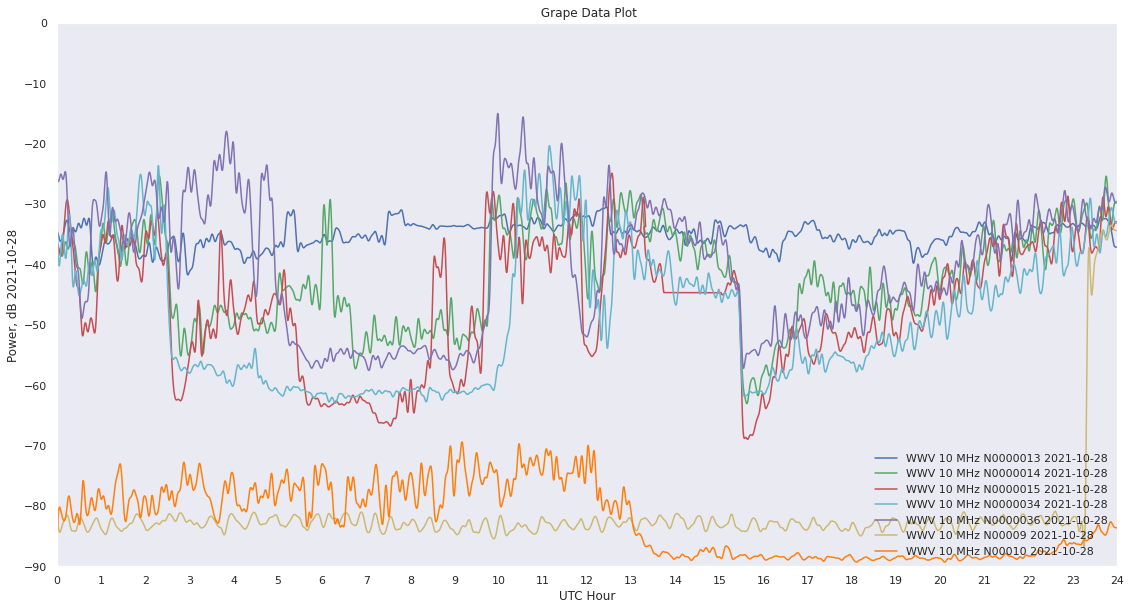

In [9]:
# # ....and plot:
foo = multiplot()

## Keogram of long-term data
Let's generate a heatmap of one node's data to show trends over the long term.

In [10]:
# Set colormap parameters for keograms. Red/Blue suits Doppler shift.

color = plt.get_cmap('RdBu')   # default color
color.set_bad('black')         # distinct color if value is bad. Try "lightblue" for something milder...

/home/pliny/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))



In [11]:
# Define function to generate a heatmap matrix - given node, dates, frequency:
def keomaker(nodenum, start = [2018, 1, 1, 0, 0, 0], end = [date.today().year, date.today().month, date.today().day], 
             cfreq = 5e6, cadence = '5min', quant='freq', df = df):
    tic = time.time()                                                       # set up time clock to see how long this takes
    # First we select stations of interest:
    keolist = df[df['Node']==nodenum]         # selecting one node
    
    #saved data directory
    homepath = ""
    path = homepath + 'data/'
    
#     namelist = gather(gantt=keolist, start = start, end = end)                # bug passing variables
    gantt = keolist
    plotfiles = gantt.loc[gantt['Frequency'] == cfreq] # only a specific frequency...
    sTime_tmp = datetime.datetime(start[0], start[1], start[2], tzinfo = pytz.UTC)
    eTime_tmp = datetime.datetime(end[0], end[1], end[2], tzinfo = pytz.UTC)
    namelist = plotfiles[(plotfiles['Datetime'] >= sTime_tmp) & (plotfiles['Datetime'] <= eTime_tmp)].Filename
    print(str(len(namelist)) + ' files found.')
    
    
    names=namelist.values.tolist()
    listsave(names)
    
    toc = time.time() - tic                                     # See how much time has passed
    print(str(toc) + ' seconds to set up keolist.')             # Feedback to user
    
    toc = time.time() - tic                                     # See how much time has passed
    print("Files downloaded at " + str(toc) + ' seconds.')             # Feedback to user
    keofiles = keolist["Filename"].tolist() # generate a list of filenames
    urls = ["https://wwvarc.org/wwvarc.net/ftp/grape/" + s for s in keofiles]

    # Preallocate:
    sTime_tmp = dt.datetime(start[0], start[1], start[2], tzinfo = pytz.UTC)
    eTime_tmp = dt.datetime(end[0], end[1], end[2], tzinfo = pytz.UTC)
    t = pd.date_range(start=sTime_tmp,
                      end=eTime_tmp,
                      freq = cadence)
    keo = pd.DataFrame(np.nan, index=t, columns=[quant])
    keo[quant] = 0
    keo = pd.pivot_table(keo, index=keo.index.time, columns=keo.index.date, values=quant)  # Create pivot table
    keo.columns = keo.columns.astype(str)                                                  # To match data index
    print("Table of values preallocated from " + keo.columns[1]  + " to " + keo.columns[keo.shape[1]-1]  + ". ")
    print("Table size: " + str(keo.shape))


    for url in names:
        try:
            toc = time.time() - tic                                     # See how much time has passed
    #         print('At ' + str(toc) + ' seconds, started downloading ' + url)             # Feedback to user
            rawdata    = pd.read_csv('data/' + url.strip('\n'), comment = '#', parse_dates=[0])
            toc = time.time() - tic                                     # See how much time has passed
    #         print('At ' + str(toc) + ' seconds, started parsing ' + url)             # Feedback to user
            data = rawdata.drop_duplicates(subset=['UTC'], keep='last')      # drop duplicates
            datestring = data['UTC'].iloc[4].date().strftime('%Y-%m-%d')     # what's the date?
            current_date = data['UTC'].iloc[4].date()
            data['UTC'] = pd.to_datetime(data['UTC'], utc=True)             # convert from string to datetime
            data = data.set_index(['UTC'])                                   # index by datetime
            data = data.resample(cadence).pad()                               # Resample *within* for loop
            data.index = pd.Series([val.time() for val in data.index])       # Ditch date from datetime

            if quant == 'amp':
                data = data.drop(columns = ['Freq'])
                print('Looking at amplitude.')
            if quant == 'freq':
                data = data.drop(columns = ['Vpk'])                          # let's just look at frequency information.
                data['Freq'] = data['Freq']-cfreq                           # Remove the offset from the freq column.
            Freq_string= datestring                                          # Rename col with date
            Vpk_string = "Vpk: " + datestring                                # Rename col with date
            data = data.rename(columns={'Freq': datestring, 'Vpk': datestring})
            toc = time.time() - tic                                     # See how much time has passed
    #         print('At ' + str(toc) + ' seconds, finished reformatting ' + url)             # Feedback to user
            keo.loc[:, datestring] = data          # Maybe try this?
    #         os.remove(filename) #  comment in to delete the file from the working directory when we're done using it

            toc = time.time() - tic                                     # See how much time has passed
            print('At ' + str(toc) + ' seconds, merged ' + url)             # Feedback to user
        except Exception as e:
            print('Ran into an issue with ' + str(url))
            raise e
            continue
            
    toc = time.time() - tic                                     # See how much time has passed
    print(str(toc) + ' seconds to complete this task.')         # Feedback to user
    return keo


1088 files found.
0.02511286735534668 seconds to set up keolist.
Files downloaded at 0.0252685546875 seconds.
Table of values preallocated from 2019-06-02 to 2022-06-01. 
Table size: (288, 1097)
At 0.7157492637634277 seconds, merged 2019-06-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 0.9135539531707764 seconds, merged 2019-06-02T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 1.190223217010498 seconds, merged 2019-06-03T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 1.4514825344085693 seconds, merged 2019-06-04T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 1.7537524700164795 seconds, merged 2019-06-05T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 2.0148329734802246 seconds, merged 2019-06-06T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv


/home/pliny/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



At 2.269282579421997 seconds, merged 2019-06-07T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 2.530628204345703 seconds, merged 2019-06-08T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 2.7820937633514404 seconds, merged 2019-06-09T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 3.0341169834136963 seconds, merged 2019-06-10T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 3.283186674118042 seconds, merged 2019-06-11T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 3.5386745929718018 seconds, merged 2019-06-12T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 3.7833547592163086 seconds, merged 2019-06-13T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 4.082094669342041 seconds, merged 2019-06-14T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 4.324944972991943 seconds, merged 2019-06-15T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 4.574250936508179 seconds, merged 2019-06-16T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 4.817633867263794 seconds, merged 2019-06-17T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 5.061520099639893 seconds

At 25.71247148513794 seconds, merged 2019-09-10T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 25.961697816848755 seconds, merged 2019-09-11T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 26.210397005081177 seconds, merged 2019-09-12T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 26.402050256729126 seconds, merged 2019-09-13T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 26.699559926986694 seconds, merged 2019-09-14T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 26.960760354995728 seconds, merged 2019-09-15T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 27.230732917785645 seconds, merged 2019-09-16T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 27.480544328689575 seconds, merged 2019-09-17T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 27.742130756378174 seconds, merged 2019-09-18T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 27.94014620780945 seconds, merged 2019-09-19T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 28.247052669525146 seconds, merged 2019-09-20T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 28.490483045578003 s

At 50.34349846839905 seconds, merged 2019-12-12T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 50.59098243713379 seconds, merged 2019-12-13T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 50.83644151687622 seconds, merged 2019-12-14T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 51.09379768371582 seconds, merged 2019-12-15T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 51.37805509567261 seconds, merged 2019-12-16T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 51.63105916976929 seconds, merged 2019-12-17T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 51.9151668548584 seconds, merged 2019-12-18T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 52.16801452636719 seconds, merged 2019-12-19T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 52.42368936538696 seconds, merged 2019-12-20T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 52.67722702026367 seconds, merged 2019-12-21T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 52.92484760284424 seconds, merged 2019-12-22T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 53.16716456413269 seconds, mer

At 73.33042025566101 seconds, merged 2020-03-15T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 73.58475828170776 seconds, merged 2020-03-16T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 73.82870078086853 seconds, merged 2020-03-17T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 74.0715799331665 seconds, merged 2020-03-18T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 74.32690787315369 seconds, merged 2020-03-19T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 74.57693386077881 seconds, merged 2020-03-20T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 74.81718516349792 seconds, merged 2020-03-21T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 75.05761241912842 seconds, merged 2020-03-22T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 75.29749774932861 seconds, merged 2020-03-23T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 75.53607749938965 seconds, merged 2020-03-24T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 75.77857875823975 seconds, merged 2020-03-25T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 76.02674984931946 seconds, mer

At 96.39021873474121 seconds, merged 2020-06-17T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 96.64355254173279 seconds, merged 2020-06-18T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 96.89916157722473 seconds, merged 2020-06-19T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 97.1480073928833 seconds, merged 2020-06-20T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 97.38928961753845 seconds, merged 2020-06-21T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 97.63637447357178 seconds, merged 2020-06-22T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 97.8805251121521 seconds, merged 2020-06-23T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 98.13398122787476 seconds, merged 2020-06-24T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 98.3791434764862 seconds, merged 2020-06-25T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 98.62453699111938 seconds, merged 2020-06-26T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 98.86723303794861 seconds, merged 2020-06-27T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 99.11333966255188 seconds, merge

At 125.67751169204712 seconds, merged 2020-09-20T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 125.94749069213867 seconds, merged 2020-09-21T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 126.22098779678345 seconds, merged 2020-09-22T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 126.48971462249756 seconds, merged 2020-09-23T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 126.75880670547485 seconds, merged 2020-09-24T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 127.12538743019104 seconds, merged 2020-09-25T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 127.45122385025024 seconds, merged 2020-09-26T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 127.75257134437561 seconds, merged 2020-09-27T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 128.05508065223694 seconds, merged 2020-09-28T000001Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 128.3636713027954 seconds, merged 2020-09-29T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 128.72196006774902 seconds, merged 2020-09-30T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 129.01565670967102 

At 152.9322066307068 seconds, merged 2020-12-25T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 153.179349899292 seconds, merged 2020-12-26T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 153.44190669059753 seconds, merged 2020-12-27T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 153.69676971435547 seconds, merged 2020-12-28T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 153.96887683868408 seconds, merged 2020-12-29T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 154.21903705596924 seconds, merged 2020-12-30T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 154.46900057792664 seconds, merged 2020-12-31T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 154.7238893508911 seconds, merged 2021-01-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 154.99768161773682 seconds, merged 2021-01-02T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 155.2511556148529 seconds, merged 2021-01-03T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 155.51414942741394 seconds, merged 2021-01-04T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 155.78690934181213 seco

At 180.4908730983734 seconds, merged 2021-03-28T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 180.7579789161682 seconds, merged 2021-03-29T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 181.0360860824585 seconds, merged 2021-03-30T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 181.37838554382324 seconds, merged 2021-03-31T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 181.67971301078796 seconds, merged 2021-04-01T000001Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 182.18456053733826 seconds, merged 2021-04-02T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 182.61724138259888 seconds, merged 2021-04-03T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 183.04374432563782 seconds, merged 2021-04-04T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 183.47565937042236 seconds, merged 2021-04-05T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 183.86875128746033 seconds, merged 2021-04-06T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 184.21031093597412 seconds, merged 2021-04-07T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 184.49273252487183 se

At 205.18622255325317 seconds, merged 2021-06-29T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 205.42740058898926 seconds, merged 2021-06-30T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 205.66997861862183 seconds, merged 2021-07-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 205.90962600708008 seconds, merged 2021-07-02T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 206.15067386627197 seconds, merged 2021-07-03T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 206.38318300247192 seconds, merged 2021-07-04T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 206.61718273162842 seconds, merged 2021-07-05T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 206.85683727264404 seconds, merged 2021-07-06T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 207.14226913452148 seconds, merged 2021-07-07T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 207.3944754600525 seconds, merged 2021-07-08T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 207.63854312896729 seconds, merged 2021-07-09T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 207.80810928344727 

At 227.84302139282227 seconds, merged 2021-09-30T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 228.0869472026825 seconds, merged 2021-10-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 228.32903957366943 seconds, merged 2021-10-02T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 228.56998133659363 seconds, merged 2021-10-03T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 228.81231427192688 seconds, merged 2021-10-04T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 229.05598330497742 seconds, merged 2021-10-05T000001Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 229.29224395751953 seconds, merged 2021-10-06T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 229.53179574012756 seconds, merged 2021-10-07T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 229.78210473060608 seconds, merged 2021-10-08T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 230.03042483329773 seconds, merged 2021-10-09T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 230.2681872844696 seconds, merged 2021-10-10T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 230.51220035552979 s

At 250.98093676567078 seconds, merged 2022-01-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 251.21750569343567 seconds, merged 2022-01-02T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 251.4720950126648 seconds, merged 2022-01-03T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 251.70905113220215 seconds, merged 2022-01-04T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 251.9463987350464 seconds, merged 2022-01-05T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 252.18541407585144 seconds, merged 2022-01-06T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 252.4282259941101 seconds, merged 2022-01-07T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 252.6937370300293 seconds, merged 2022-01-08T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 252.947904586792 seconds, merged 2022-01-09T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 253.18928456306458 seconds, merged 2022-01-10T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 253.42709875106812 seconds, merged 2022-01-11T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 253.66958332061768 secon

At 273.8213560581207 seconds, merged 2022-04-04T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 274.0578947067261 seconds, merged 2022-04-05T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 274.302885055542 seconds, merged 2022-04-06T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 274.54434967041016 seconds, merged 2022-04-07T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 274.7826907634735 seconds, merged 2022-04-08T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 275.0255813598633 seconds, merged 2022-04-09T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 275.26161003112793 seconds, merged 2022-04-10T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 275.5032925605774 seconds, merged 2022-04-11T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 275.50993275642395 seconds, merged 2022-04-12T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 275.5459289550781 seconds, merged 2022-04-14T205109Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 275.79807233810425 seconds, merged 2022-04-15T000001Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
At 276.04019141197205 seconds

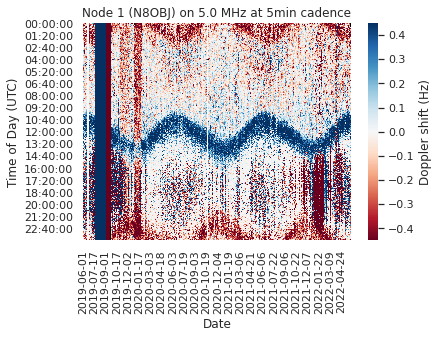

In [12]:
# Illustrative keogram for N8OBJ's Node 1, our longest dataset:
node = 1
cfreq = 5e6
cadence = '5min'
keo = keomaker(nodenum=node, start = [2019, 6, 1, 0, 0, 0], end = [2022, 6, 1, 0, 0, 0], cfreq=cfreq, cadence=cadence, quant='freq')
h_map = sns.heatmap(data=keo, cmap=color, robust = 1, center = 0,  vmin=-.45, vmax=.45, cbar_kws={'label':'Doppler shift (Hz)'})

# Generate plot title:
plotTitle = 'Node ' + str(node)+' ('+nodes.Callsign[node]+') on ' + str(cfreq/1e6)+' MHz at '+cadence + ' cadence'

# Set title and labels for axes
h_map.set(xlabel="Date",
       ylabel="Time of Day (UTC)",
       title=plotTitle)
plt.show()
